In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from datetime import datetime
from neqsim.thermo import TPflash
from src.data.handlers import DataLoader
from src.models.classification.train_models import ClassificationTraining
from src.models.classification.evaluate_models import ClassificationAnalysis
from src.utils import create_fluid
from src.utils.constants import P_MIN_MAX, T_MIN_MAX, K_FOLDS
from typing import Tuple

plt.style.use("seaborn-v0_8-paper")
plt.style.use(os.path.join("src", "visualization", "styles", "l3_mod.mplstyle"))

DPI = 600

In [26]:
k_folds = K_FOLDS
training = ClassificationTraining()
analysis = ClassificationAnalysis()
data_loader = DataLoader()

cv_data, _ = data_loader.load_cross_validation_datasets(problem="classification")
valid_data = cv_data["valid"]
print("Loading training models results")
results = training.load_training_models()
print("Loading performance indices results")
indices = analysis.load_performance_indices()
viz_folder = os.path.join("data", "models", "classification", "saved_viz")

if not os.path.isdir(viz_folder):
    os.makedirs(viz_folder)

print("Starting phase diagram generation")
model_name = "SVM #8"
model_type = "svm"

output = [o for o in results["outputs"] if o["model_name"] == model_name][0]
data = pd.concat([valid["features"] for valid in valid_data], axis=0, ignore_index=True)

# generate phase diagram data
size = 400

# Data preparation
pressure = np.linspace(*P_MIN_MAX, num=size)
temperature = np.linspace(*T_MIN_MAX, num=size)

PP, TT = np.meshgrid(pressure, temperature)
P = PP.flatten().reshape(-1, 1)
T = TT.flatten().reshape(-1, 1)

sample = np.random.randint(data.shape[0])
data = data.iloc[sample : sample + 1, :].copy()
data = pd.DataFrame(np.tile(data.values, (size * size, 1)), columns=data.columns)
data[["P", "T"]] = np.c_[P, T]
print(f"Sample size: {size} x {size} = {data.shape[0]}")

# Preprocessing
features = data.copy()
features = features.apply(lambda s: pd.to_numeric(s))
P_min, P_max = P_MIN_MAX
T_min, T_max = T_MIN_MAX
features["P"] = (features["P"] - P_min) / (P_max - P_min)
features["T"] = (features["T"] - T_min) / (T_max - T_min)

composition = data.iloc[0, data.columns.str.startswith("z")].to_dict()

# Fluid creation
fluid = create_fluid(composition)

model_id = output["model_id"]
model_name = output["model_name"]
labels = []
# Call simulation
start = datetime.now()
for d in data.to_dict(orient="records"):
    fluid.setPressure(d["P"], "bara")
    fluid.setTemperature(d["T"], "K")

    TPflash(fluid)

    phases = [p for p in fluid.getPhases() if p]
    label_name = ",".join([str(phase.getPhaseTypeName()) for phase in phases])

    if label_name == "oil,liquid":
        labels.append("oil")
    elif label_name == "gas,liquid":
        labels.append("gas")
    elif label_name == "gas,oil":
        labels.append("mix")

labels = pd.get_dummies(pd.Series(labels)).astype(int).values

print(f"Model ID: {model_id}, model name: {model_name}")
print(f"Flash simulation Elapsed Time: {datetime.now() - start}")

Loading training models results
Loading performance indices results
Starting phase diagram generation
Sample size: 400 x 400 = 160000
Model ID: 8, model name: SVM #8
Flash simulation Elapsed Time: 0:04:47.139403


Fold: 1, SVM Elapsed Time: 0:00:00.602382
Fold: 2, SVM Elapsed Time: 0:00:00.624852
Fold: 3, SVM Elapsed Time: 0:00:00.605082
Fold: 4, SVM Elapsed Time: 0:00:00.610818
Creating phase diagram and neural net probabilities heatmap plot


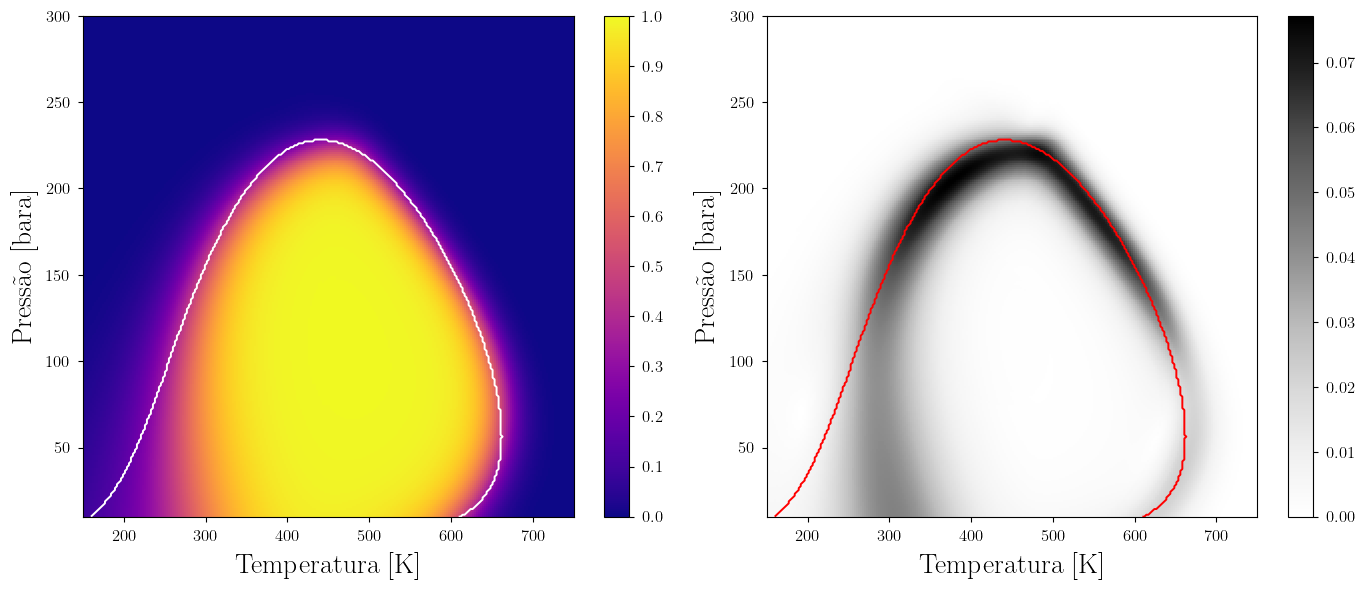

In [27]:
label: int = 1
fold: int = 0
use_mean_prediction = True
xlim: Tuple[float] = (TT.min(), 750.0)
ylim: Tuple[float] = (PP.min(), 300.0)

# Call neural network model predictions
if use_mean_prediction:  # Mean and Standard Dev for all folds
    ps = []
    for fold_info in output["folds"]:
        model = fold_info["model"]
        print(f"Fold: {fold_info['fold']}, ", end="")
        start = datetime.now()
        if output["model_type"] == "neural_network":
            logits = model(features.values)
            ps.append(tf.nn.softmax(logits, axis=1).numpy())
            print(f"Neural Net Elapsed Time: {datetime.now() - start}")
        elif output["model_type"] == "svm":
            probs = model.predict_proba(features.values)
            ps.append(probs)
            print(f"SVM Elapsed Time: {datetime.now() - start}")
    mean_p = np.array(ps).mean(axis=0)
    std_p = np.array(ps).std(axis=0) / np.sqrt(K_FOLDS - 1)

    # plot phase diagram and neural net probabilities heatmap
    print("Creating phase diagram and neural net probabilities heatmap plot")
    f, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].contour(TT, PP, labels[:, label].reshape(size, size), levels=0, colors="white")
    axs[1].contour(TT, PP, labels[:, label].reshape(size, size), levels=0, colors="red")
    pcm0 = axs[0].pcolormesh(TT, PP, mean_p[:, label].reshape(size, size), vmin=0.0, vmax=1.0, cmap="plasma")
    pcm1 = axs[1].pcolormesh(TT, PP, std_p[:, label].reshape(size, size), cmap="Greys")
    f.colorbar(pcm0, ax=axs[0], ticks=np.linspace(0, 1, num=11, endpoint=True))
    f.colorbar(pcm1, ax=axs[1])

    if xlim:
        axs[0].set_xlim(xlim)  # Temperature
        axs[1].set_xlim(xlim)
    if ylim:
        axs[0].set_ylim(ylim)  # Pressure
        axs[1].set_ylim(ylim)

    # f.suptitle(model_name.replace("#", "\#"))
    axs[0].set_xlabel("Temperatura [K]", size=20)
    axs[1].set_xlabel("Temperatura [K]", size=20)
    axs[0].set_ylabel("Pressão [bara]", size=20)
    axs[1].set_ylabel("Pressão [bara]", size=20)
    f.tight_layout()
    f.savefig(
        os.path.join(viz_folder, f"phase_diagram_w_uncertainty_model_id={model_id}.png"),
        dpi=DPI,
    )
else:  # For specific fold
    model = output["folds"][fold]["model"]
    start = datetime.now()
    if output["model_type"] == "neural_network":
        logits = model(features.values)
        probs = tf.nn.softmax(logits, axis=1).numpy()
        print(f"Neural Net Elapsed Time: {datetime.now() - start}")
    elif output["model_type"] == "svm":
        probs = model.predict_proba(features.values)
        print(f"SVM Elapsed Time: {datetime.now() - start}")

    # plot phase diagram and neural net probabilities heatmap
    print("Creating phase diagram and neural net probabilities heatmap plot")
    f, ax = plt.subplots()
    ax.contour(TT, PP, labels[:, label].reshape(size, size), levels=0, colors="white")
    pcm = ax.pcolormesh(TT, PP, probs[:, label].reshape(size, size), vmin=0.0, vmax=1.0, cmap="plasma")
    f.colorbar(pcm, ax=ax, extend="max")

    if xlim:
        ax.set_xlim(xlim)  # Temperature
    if ylim:
        ax.set_ylim(ylim)  # Pressure

    ax.set_title(model_name.replace("#", "\#"))
    ax.set_xlabel("Temperatura [K]")
    ax.set_ylabel("Pressão [bara]")
    f.tight_layout()
    f.savefig(os.path.join(viz_folder, f"phase_diagram_model_id={model_id}.png"), dpi=DPI)
plt.show()